In [1]:
from collections import defaultdict
import glob
import json
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [5]:
folder = '/home/olga/googledrive/brawand2011/data/kmermaid/results_peptide7/extract_coding'
classification_percentages_metadata = pd.read_csv(f'{folder}/classification_percentages_metadata.csv')
print(classification_percentages_metadata.shape)
classification_percentages_metadata.head()

(147, 16)


,Non-coding,Coding,No translation frames without stop codons,All translations shorter than peptide k-mer size + 1,Read length was shorter than 3 * peptide k-mer size,Low complexity peptide in protein encoding,filename,sample_id,sra_id,geo_id,species_abbrev,tissue_abbrev,sex,replicate,species,tissue
0,68.549280,26.416538,4.030022,0.872370,0.075918,0.055873,/home/olga/data_lg/kmer-hashing/brawand2011/km...,SRR306802_GSM752655_ggo_cb_F_1,SRR306802,GSM752655,ggo,cb,F,1,Gorilla,Cerebellum
1,76.458843,18.913639,3.486677,0.801294,0.064244,0.275304,/home/olga/data_lg/kmer-hashing/brawand2011/km...,SRR306765_GSM752619_mmu_cb_M_2,SRR306765,GSM752619,mmu,cb,M,2,Mouse,Cerebellum
2,78.203007,16.819733,4.308748,0.599139,0.042650,0.026723,/home/olga/data_lg/kmer-hashing/brawand2011/km...,SRR306782_GSM752636_mml_ht_F_1,SRR306782,GSM752636,mml,ht,F,1,Macaque,Heart
3,78.245375,15.101219,5.841887,0.738069,0.015459,0.057990,/home/olga/data_lg/kmer-hashing/brawand2011/km...,SRR306750_GSM752598_mdo_ht_M_1,SRR306750,GSM752598,mdo,ht,M,1,Opossum,Heart
4,86.181560,9.365462,3.264713,1.088898,0.039388,0.059979,/home/olga/data_lg/kmer-hashing/brawand2011/km...,SRR306753_GSM752606_mdo_lv_F_1,SRR306753,GSM752606,mdo,lv,F,1,Opossum,Liver


In [6]:
base_folder = '/home/olga/ibm_lg/kmer-hashing/brawand2011/nfcore-rnaseq'
globber = f'{base_folder}/*/*/rseqc/read_distribution/*'
glob.glob(globber)

['/home/olga/ibm_lg/kmer-hashing/brawand2011/nfcore-rnaseq/human/single_end/rseqc/read_distribution/SRR306850_GSM752701_hsa_ht_M_2Aligned.sortedByCoord.out.read_distribution.txt',
 '/home/olga/ibm_lg/kmer-hashing/brawand2011/nfcore-rnaseq/human/single_end/rseqc/read_distribution/SRR306846_GSM752698_hsa_cb_M_1Aligned.sortedByCoord.out.read_distribution.txt',
 '/home/olga/ibm_lg/kmer-hashing/brawand2011/nfcore-rnaseq/human/single_end/rseqc/read_distribution/SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.read_distribution.txt',
 '/home/olga/ibm_lg/kmer-hashing/brawand2011/nfcore-rnaseq/human/single_end/rseqc/read_distribution/SRR306856_GSM752706_hsa_lv_M_2Aligned.sortedByCoord.out.read_distribution.txt',
 '/home/olga/ibm_lg/kmer-hashing/brawand2011/nfcore-rnaseq/human/single_end/rseqc/read_distribution/SRR306844_GSM752697_hsa_cb_F_1Aligned.sortedByCoord.out.read_distribution.txt',
 '/home/olga/ibm_lg/kmer-hashing/brawand2011/nfcore-rnaseq/human/single_end/rseqc/read_distribution/

Steal [MultiQC's](https://github.com/ewels/MultiQC/blob/master/multiqc/modules/rseqc/read_distribution.py) parsing

In [40]:
import re

first_regexes = {
    'total_reads': r"Total Reads\s+(\d+)\s*",
    'total_tags': r"Total Tags\s+(\d+)\s*",
    'total_assigned_tags': r"Total Assigned Tags\s+(\d+)\s*",
}
second_regexes = {
    'cds_exons': r"CDS_Exons\s+(\d+)\s+(\d+)\s+([\d\.]+)\s*",
    '5_utr_exons': r"5'UTR_Exons\s+(\d+)\s+(\d+)\s+([\d\.]+)\s*",
    '3_utr_exons': r"3'UTR_Exons\s+(\d+)\s+(\d+)\s+([\d\.]+)\s*",
    'introns': r"Introns\s+(\d+)\s+(\d+)\s+([\d\.]+)\s*",
    'tss_up_1kb': r"TSS_up_1kb\s+(\d+)\s+(\d+)\s+([\d\.]+)\s*",
    'tss_up_5kb': r"TSS_up_5kb\s+(\d+)\s+(\d+)\s+([\d\.]+)\s*",
    'tss_up_10kb': r"TSS_up_10kb\s+(\d+)\s+(\d+)\s+([\d\.]+)\s*",
    'tes_down_1kb': r"TES_down_1kb\s+(\d+)\s+(\d+)\s+([\d\.]+)\s*",
    'tes_down_5kb': r"TES_down_5kb\s+(\d+)\s+(\d+)\s+([\d\.]+)\s*",
    'tes_down_10kb': r"TES_down_10kb\s+(\d+)\s+(\d+)\s+([\d\.]+)\s*",
}

def parse_rseqc_read_distribution(filename):
    sample_id = os.path.basename(filename).split('Aligned.sortedByCoord.out.read_distribution.txt')[0]
    
    # If there is a double number at the end, then this was a paired-end 
    # read set and need to remove the last _1
    if re.search(r'\d_\d', sample_id) is not None:
        sample_id = re.findall('(\w+)_\d', sample_id)[0]
    d = dict()
    with open(filename) as f:
        file_content = f.read()
        for k, r in first_regexes.items():
            r_search = re.search(r, file_content, re.MULTILINE)
            if r_search:
                d[k] = int(r_search.group(1))
        for k, r in second_regexes.items():
            r_search = re.search(r, file_content, re.MULTILINE)
            if r_search:
                d['{}_total_bases'.format(k)] = int(r_search.group(1))
                d['{}_tag_count'.format(k)] = int(r_search.group(2))
                d['{}_tags_kb'.format(k)] = float(r_search.group(3))

        d['other_intergenic_tag_count'] = d['total_tags']-d['total_assigned_tags']

        # Calculate some percentages for parsed file
        if 'total_tags' in d:
            t = float(d['total_tags'])
            pcts = dict()
            for k in d:
                if k.endswith('_tag_count'):
                    pk = '{}_tag_pct'.format(k[:-10])
                    pcts[pk] = (float(d[k]) / t)*100.0
            d.update(pcts)
            
    series = pd.Series(d, name=sample_id)
    return series

filename = '/home/olga/ibm_lg/kmer-hashing/brawand2011/nfcore-rnaseq/chimpanzee/paired_end/rseqc/read_distribution/SRR306816_GSM752669_ptr_br_M_5_1Aligned.sortedByCoord.out.read_distribution.txt'
parse_rseqc_read_distribution(filename)

total_reads                   3.751575e+07
total_tags                    4.286295e+07
total_assigned_tags           3.564938e+07
cds_exons_total_bases         8.808513e+07
cds_exons_tag_count           2.128516e+07
cds_exons_tags_kb             2.416400e+02
5_utr_exons_total_bases       6.300107e+06
5_utr_exons_tag_count         3.360410e+05
5_utr_exons_tags_kb           5.334000e+01
3_utr_exons_total_bases       2.959627e+07
3_utr_exons_tag_count         7.649711e+06
3_utr_exons_tags_kb           2.584700e+02
introns_total_bases           1.418158e+09
introns_tag_count             4.878900e+06
introns_tags_kb               3.440000e+00
tss_up_1kb_total_bases        2.880640e+07
tss_up_1kb_tag_count          5.329400e+04
tss_up_1kb_tags_kb            1.850000e+00
tss_up_5kb_total_bases        1.301524e+08
tss_up_5kb_tag_count          6.452800e+05
tss_up_5kb_tags_kb            4.960000e+00
tss_up_10kb_total_bases       2.352638e+08
tss_up_10kb_tag_count         9.056750e+05
tss_up_10kb

In [41]:
base_folder = '/home/olga/ibm_lg/kmer-hashing/brawand2011/nfcore-rnaseq'
globber = f'{base_folder}/*/*/rseqc/read_distribution/*'

seriess = []

for filename in glob.iglob(globber):
    series = parse_rseqc_read_distribution(filename)
    seriess.append(series)
rseqc_read_distributions = pd.DataFrame(seriess)
print(rseqc_read_distributions.shape)
rseqc_read_distributions.head()

(35, 45)


,total_reads,total_tags,total_assigned_tags,cds_exons_total_bases,cds_exons_tag_count,cds_exons_tags_kb,5_utr_exons_total_bases,5_utr_exons_tag_count,5_utr_exons_tags_kb,3_utr_exons_total_bases,...,5_utr_exons_tag_pct,3_utr_exons_tag_pct,introns_tag_pct,tss_up_1kb_tag_pct,tss_up_5kb_tag_pct,tss_up_10kb_tag_pct,tes_down_1kb_tag_pct,tes_down_5kb_tag_pct,tes_down_10kb_tag_pct,other_intergenic_tag_pct
SRR306850_GSM752701_hsa_ht_M_2,21292867.0,25258488.0,24387237.0,97553390.0,19675431.0,201.69,6708876.0,376547.0,56.13,32534150.0,...,1.490774,11.312506,5.375496,0.079280,0.133900,0.165841,0.118602,0.252719,0.309730,3.449339
SRR306846_GSM752698_hsa_cb_M_1,15800648.0,18379213.0,17615565.0,97553390.0,12662565.0,129.80,6708876.0,196081.0,29.23,32534150.0,...,1.066863,15.304480,9.503900,0.103867,0.230325,0.325966,0.218132,0.578784,0.747714,4.154955
SRR306838_GSM752691_hsa_br_F_1,780690.0,889131.0,867476.0,97553390.0,537910.0,5.51,6708876.0,4158.0,0.62,32534150.0,...,0.467648,26.638932,8.776997,0.058821,0.188049,0.274425,0.299169,0.725877,0.908078,2.435524
SRR306856_GSM752706_hsa_lv_M_2,20479674.0,25412159.0,24423554.0,97553390.0,20272780.0,207.81,6708876.0,244771.0,36.48,32534150.0,...,0.963204,8.959223,5.672659,0.069628,0.152541,0.290511,0.170481,0.361547,0.448215,3.890283
SRR306844_GSM752697_hsa_cb_F_1,26696068.0,30804199.0,29400439.0,97553390.0,20372273.0,208.83,6708876.0,514939.0,76.75,32534150.0,...,1.671652,12.543702,13.763228,0.142536,0.290792,0.399877,0.244973,0.686747,0.929773,4.557041


In [42]:
rseqc_read_distributions

,total_reads,total_tags,total_assigned_tags,cds_exons_total_bases,cds_exons_tag_count,cds_exons_tags_kb,5_utr_exons_total_bases,5_utr_exons_tag_count,5_utr_exons_tags_kb,3_utr_exons_total_bases,...,5_utr_exons_tag_pct,3_utr_exons_tag_pct,introns_tag_pct,tss_up_1kb_tag_pct,tss_up_5kb_tag_pct,tss_up_10kb_tag_pct,tes_down_1kb_tag_pct,tes_down_5kb_tag_pct,tes_down_10kb_tag_pct,other_intergenic_tag_pct
SRR306850_GSM752701_hsa_ht_M_2,21292867.0,25258488.0,24387237.0,97553390.0,19675431.0,201.69,6708876.0,376547.0,56.13,32534150.0,...,1.490774,11.312506,5.375496,0.079280,0.133900,0.165841,0.118602,0.252719,0.309730,3.449339
SRR306846_GSM752698_hsa_cb_M_1,15800648.0,18379213.0,17615565.0,97553390.0,12662565.0,129.80,6708876.0,196081.0,29.23,32534150.0,...,1.066863,15.304480,9.503900,0.103867,0.230325,0.325966,0.218132,0.578784,0.747714,4.154955
SRR306838_GSM752691_hsa_br_F_1,780690.0,889131.0,867476.0,97553390.0,537910.0,5.51,6708876.0,4158.0,0.62,32534150.0,...,0.467648,26.638932,8.776997,0.058821,0.188049,0.274425,0.299169,0.725877,0.908078,2.435524
SRR306856_GSM752706_hsa_lv_M_2,20479674.0,25412159.0,24423554.0,97553390.0,20272780.0,207.81,6708876.0,244771.0,36.48,32534150.0,...,0.963204,8.959223,5.672659,0.069628,0.152541,0.290511,0.170481,0.361547,0.448215,3.890283
SRR306844_GSM752697_hsa_cb_F_1,26696068.0,30804199.0,29400439.0,97553390.0,20372273.0,208.83,6708876.0,514939.0,76.75,32534150.0,...,1.671652,12.543702,13.763228,0.142536,0.290792,0.399877,0.244973,0.686747,0.929773,4.557041
SRR306855_GSM752705_hsa_lv_M_1,21960165.0,26848271.0,25799169.0,97553390.0,21789234.0,223.36,6708876.0,126948.0,18.92,32534150.0,...,0.472835,9.830242,4.077585,0.051337,0.103321,0.133573,0.192631,0.363290,0.421308,3.907522
SRR306854_GSM752705_hsa_lv_M_1,4522780.0,5069567.0,4838211.0,97553390.0,3933657.0,40.32,6708876.0,22615.0,3.37,32534150.0,...,0.446093,10.984982,5.466384,0.123975,0.241046,0.295469,0.337129,0.555452,0.649898,4.563624
SRR306849_GSM752700_hsa_ht_M_1,14274919.0,16907263.0,15884800.0,97553390.0,13048919.0,133.76,6708876.0,165992.0,24.74,32534150.0,...,0.981779,7.265061,8.076825,0.076086,0.130323,0.166449,0.078830,0.220450,0.283038,6.047478
SRR306848_GSM752700_hsa_ht_M_1,6943569.0,7641330.0,7188113.0,97553390.0,5788876.0,59.34,6708876.0,70803.0,10.55,32534150.0,...,0.926580,7.977826,8.744577,0.144962,0.224398,0.276863,0.123565,0.297658,0.385587,5.931127
SRR306847_GSM752699_hsa_ht_F_1,390128.0,430498.0,419659.0,97553390.0,317984.0,3.26,6708876.0,1351.0,0.20,32534150.0,...,0.313823,13.413070,9.244642,0.035773,0.100813,0.150523,0.169803,0.392569,0.495937,2.517782


In [43]:
rseqc_read_distributions['cds_exons_tag_pct']

SRR306850_GSM752701_hsa_ht_M_2    77.896314
SRR306846_GSM752698_hsa_cb_M_1    68.896122
SRR306838_GSM752691_hsa_br_F_1    60.498397
SRR306856_GSM752706_hsa_lv_M_2    79.775906
SRR306844_GSM752697_hsa_cb_F_1    66.134727
SRR306855_GSM752705_hsa_lv_M_1    81.156936
SRR306854_GSM752705_hsa_lv_M_1    77.593550
SRR306849_GSM752700_hsa_ht_M_1    77.179370
SRR306848_GSM752700_hsa_ht_M_1    75.757440
SRR306847_GSM752699_hsa_ht_F_1    73.864222
SRR306858_GSM752708_hsa_ts_M_2    75.306782
SRR306843_GSM752696_hsa_br_M_5    70.749943
SRR306845_GSM752698_hsa_cb_M_1    66.040348
SRR306857_GSM752707_hsa_ts_M_1    78.315851
SRR306851_GSM752702_hsa_kd_F_1    74.508421
SRR306853_GSM752704_hsa_kd_M_2    74.493465
SRR306841_GSM752694_hsa_br_M_2    67.432900
SRR306839_GSM752692_hsa_br_M_3    74.759071
SRR306842_GSM752695_hsa_br_M_4    68.541403
SRR306840_GSM752693_hsa_br_M_1    66.386154
SRR306818_GSM752671_ptr_cb_M_1    56.453531
SRR306821_GSM752674_ptr_kd_F_1    58.334995
SRR306825_GSM752678_ptr_ts_M_1  

In [44]:
pattern = r'\d_\d'
%timeit re.findall(pattern, "SRR306814_GSM752667_ptr_br_M_3_1")

2.26 µs ± 243 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [45]:
pattern2 = '(\w+)_1'
re.findall(pattern2, "SRR306814_GSM752667_ptr_br_M_3_1")

['SRR306814_GSM752667_ptr_br_M_3']

In [46]:
%timeit re.search(pattern, "SRR306814_GSM752667_ptr_br_M_3_1")

2.15 µs ± 192 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [47]:
kmermaid_with_cds = classification_percentages_metadata.join(rseqc_read_distributions['cds_exons_tag_pct'], 
                                         on='sample_id', how='inner')
print(kmermaid_with_cds.shape)
kmermaid_with_cds.head()

(34, 17)


,Non-coding,Coding,No translation frames without stop codons,All translations shorter than peptide k-mer size + 1,Read length was shorter than 3 * peptide k-mer size,Low complexity peptide in protein encoding,filename,sample_id,sra_id,geo_id,species_abbrev,tissue_abbrev,sex,replicate,species,tissue,cds_exons_tag_pct
5,63.434188,31.277348,4.229160,1.007798,0.019810,0.031696,/home/olga/data_lg/kmer-hashing/brawand2011/km...,SRR306846_GSM752698_hsa_cb_M_1,SRR306846,GSM752698,hsa,cb,M,1,Human,Cerebellum,68.896122
7,56.017835,40.119855,2.909199,0.898754,0.022831,0.031526,/home/olga/data_lg/kmer-hashing/brawand2011/km...,SRR306849_GSM752700_hsa_ht_M_1,SRR306849,GSM752700,hsa,ht,M,1,Human,Heart,77.179370
12,70.747162,22.799928,6.143151,0.142532,0.143919,0.023308,/home/olga/data_lg/kmer-hashing/brawand2011/km...,SRR306840_GSM752693_hsa_br_M_1,SRR306840,GSM752693,hsa,br,M,1,Human,Brain,66.386154
19,49.656599,44.839043,3.159836,0.902119,1.414840,0.027563,/home/olga/data_lg/kmer-hashing/brawand2011/km...,SRR306856_GSM752706_hsa_lv_M_2,SRR306856,GSM752706,hsa,lv,M,2,Human,Liver,79.775906
23,65.102959,29.492489,4.621289,0.697142,0.059376,0.026745,/home/olga/data_lg/kmer-hashing/brawand2011/km...,SRR306853_GSM752704_hsa_kd_M_2,SRR306853,GSM752704,hsa,kd,M,2,Human,Kidney,74.493465


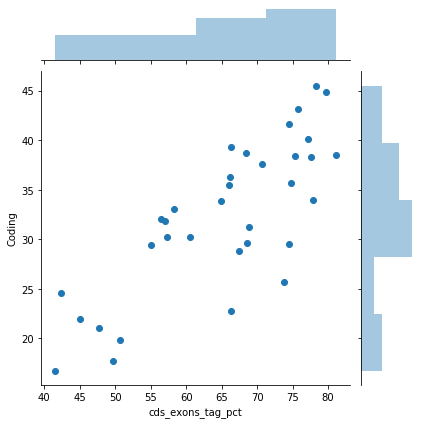

In [48]:
sns.jointplot(x='cds_exons_tag_pct', y='Coding', data=kmermaid_with_cds)

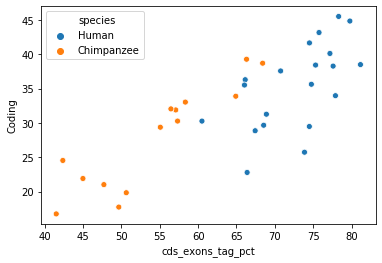

In [51]:
sns.scatterplot(x='cds_exons_tag_pct', y='Coding', data=kmermaid_with_cds, hue='species')

In [58]:
kmermaid_with_cds['cds_exons_tag_pct'].corr(kmermaid_with_cds['Coding'])

0.7903367138838998

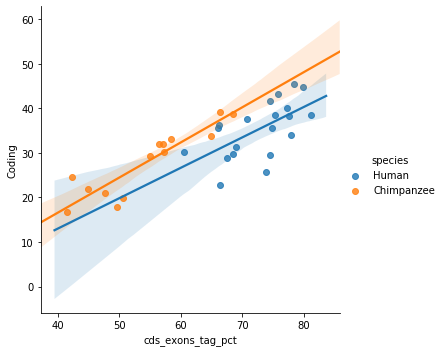

In [57]:
sns.lmplot(x='cds_exons_tag_pct', y='Coding', data=kmermaid_with_cds, hue='species')

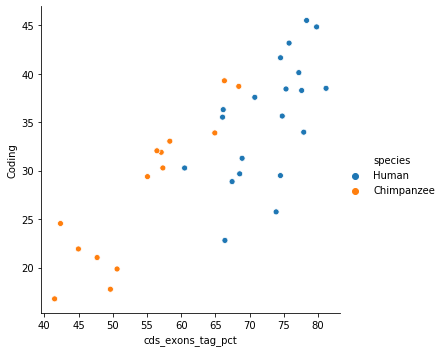

In [55]:
sns.relplot(x='cds_exons_tag_pct', y='Coding', data=kmermaid_with_cds, hue='species')

In [56]:
sns.relplot(x='cds_exons_tag_pct', y='Coding', data=kmermaid_with_cds, hue='species', kind='reg')

ValueError: Plot kind reg not recognized